In [372]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

torch.manual_seed(0)

In [373]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu = torch.tensor(0.01)

In [374]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(2001,100)
        self.Branch_L2 = nn.Linear(100,100)
        self.Branch_L3 = nn.Linear(100,100)
        self.Branch_L4 = nn.Linear(100,100)
        self.Branch_L5 = nn.Linear(100,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,20)
        self.Trunk_L3 = nn.Linear(20,20)
        self.Trunk_L4 = nn.Linear(20,20)
        self.Trunk_L5 = nn.Linear(20,100)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
#        b = F.tanh(self.Branch_L5(b))
#        b = F.tanh(self.Branch_L6(b))
        b = self.Branch_L5(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = self.Trunk_L5(tr)

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        output = torch.sum(b * tr, dim=1)

        return output
    
# model = torch.load("model_burgers_1.pt",weights_only=False)

model = DeepONet().to(device)
#model.load_state_dict(torch.load('model_burgers_1.pt'))
#model.eval().to(device)

DeepONet(
  (Branch_L1): Linear(in_features=2001, out_features=100, bias=True)
  (Branch_L2): Linear(in_features=100, out_features=100, bias=True)
  (Branch_L3): Linear(in_features=100, out_features=100, bias=True)
  (Branch_L4): Linear(in_features=100, out_features=100, bias=True)
  (Branch_L5): Linear(in_features=100, out_features=100, bias=True)
  (Trunk_L1): Linear(in_features=2, out_features=20, bias=True)
  (Trunk_L2): Linear(in_features=20, out_features=20, bias=True)
  (Trunk_L3): Linear(in_features=20, out_features=20, bias=True)
  (Trunk_L4): Linear(in_features=20, out_features=20, bias=True)
  (Trunk_L5): Linear(in_features=20, out_features=100, bias=True)
)

In [375]:
model.Branch_L1.bias


Parameter containing:
tensor([ 0.0250,  0.0035,  0.0135, -0.0149, -0.0229,  0.0164,  0.0168,  0.0099,
        -0.0029, -0.0257,  0.0019,  0.0037,  0.0251,  0.0005, -0.0241,  0.0234,
         0.0036,  0.0156,  0.0084,  0.0171, -0.0002,  0.0024,  0.0106, -0.0189,
         0.0017, -0.0145,  0.0165,  0.0063, -0.0099, -0.0056,  0.0041,  0.0207,
        -0.0242,  0.0054,  0.0068, -0.0079,  0.0232,  0.0091,  0.0091, -0.0164,
         0.0035,  0.0260,  0.0063, -0.0112,  0.0051, -0.0207,  0.0074,  0.0051,
        -0.0118,  0.0089,  0.0076, -0.0114, -0.0010, -0.0162,  0.0042, -0.0042,
        -0.0124, -0.0009,  0.0140, -0.0110, -0.0054,  0.0143, -0.0235, -0.0134,
         0.0056, -0.0040,  0.0143, -0.0215, -0.0046, -0.0084, -0.0002, -0.0003,
        -0.0139,  0.0152,  0.0116, -0.0175,  0.0128, -0.0129, -0.0136, -0.0057,
         0.0041, -0.0022, -0.0141, -0.0163,  0.0188,  0.0105,  0.0129, -0.0258,
        -0.0055,  0.0226, -0.0132, -0.0098,  0.0130, -0.0085, -0.0046,  0.0234,
        -0.0131,  

In [376]:
# database = pd.read_csv('minus_sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')
# database = pd.read_pickle("test_df.pkl") #pd.read_csv('minus_sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [377]:
# database = pd.DataFrame(database).to_numpy(dtype='float32')

In [378]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:2001])#.requires_grad_(True)
        self.x_location = torch.from_numpy(database[:,[2001]])#.requires_grad_(True)
        self.time_vale = torch.from_numpy(database[:,[2002]])#.requires_grad_(True)
        self.true_y_value = torch.from_numpy(database[:,[2003]])#.requires_grad_(True)
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [379]:
dataset_data = Data()

In [380]:
dataset_data.true_y_value

tensor([[ 1.2246e-16],
        [ 3.1416e-03],
        [ 6.2831e-03],
        ...,
        [-1.8882e-03],
        [-1.1329e-03],
        [-3.7764e-04]])

In [381]:
dataset_data.__len__()

2003001

In [382]:
y,_,_,_ = dataset_data.__getitem__(1)
#plt.plot(y)
#plt.grid()

In [383]:
train_size = int(0.6*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

batch_size = 5000

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=batch_size,shuffle=True)

In [384]:
train_size

1201800

In [385]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [386]:
num_epoch = 5000
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.0000001

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-7)

loss_rec = []

241 1


In [387]:
def grad(outputs,inputs):
    return torch.autograd.grad(outputs,inputs,grad_outputs=torch.ones_like(outputs),create_graph=True)

In [388]:
x_locations_for_computation = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

def Physics_loss_Burgers(init_conditions,time_input_physics,x_locations):
    total_temp = torch.tensor(0)
    for j in range(len(time_input_physics)):
        # Set up the input x locations as a range from 0 to 1
        # x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

        # We will calculate gradients on every time given
        time_input = time_input_physics[j]*torch.ones_like(x_locations,dtype=torch.float32)

        # Taking the slice of the initial conditions associated with that time step. Can be used in future where not just sinx is taken.
        input_1_physics = init_conditions[j,:].unsqueeze(0)
        input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)

        # Getting output 
        output_physics = model(input_1_physics.expand(len(input2_physics),-1),input2_physics)

        # Getting required gradients
        du_dt = grad(output_physics,time_input)[0]
        du_dx = grad(output_physics,x_locations)[0]
        du2_dx2 = grad(du_dx,x_locations)[0]

        # Getting the physics loss and summing it up 
        temp = torch.mean(du_dt + output_physics*du_dx - mu*du2_dx2)
        total_temp = total_temp + temp

    return total_temp

In [389]:
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)

In [390]:
time_input_physics = torch.tensor(0.2)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
#print(time_input)

In [391]:
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
#print(input2_physics)

In [392]:
#input_1_physics = input1[1,:].unsqueeze(0)
#input_1_physics.shape

In [393]:
#output_physics = model(input_1_physics,input2_physics)

In [394]:
#du_dt = grad(output_physics,time_input)[0]
#du_dx = grad(output_physics,x_locations)[0]
#du2_dx2 = grad(du_dx,x_locations)[0]
#loss_physics_burgers = torch.mean(du_dt + x_locations*du_dx - mu*du2_dx2)
#loss_physics_burgers

In [395]:
#input1[3]

In [396]:
#Physics_loss_rec = Physics_loss(input1,input_time[3])
#Physics_loss_rec

In [397]:
model.train()

for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)
        input_time.to(device)

        Outputs = model(input1,input2)

        #input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
        #target_BC1 = torch.zeros(input_time.size(0),device=device)#.to(device)
        #predicted_BC1 = model(input1,input2_BC1)
        #loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)

        #input2_BC2 = torch.cat((torch.ones(input_time.size(0),1),input_time),-1).to(device)
        #target_BC2 = torch.zeros(input_time.size(0),device=device) #.to(device)
        #predicted_BC2 = model(input1,input2_BC2)
        #loss_BC2 = torch.mean((predicted_BC2-target_BC2)**2)

        #Physics_loss = Physics_loss_Burgers(input1,input_time,x_locations_for_computation)
        
        loss = criterion(Outputs.unsqueeze(-1),Actual_y) # + (loss_BC1 + loss_BC2) + # 0.01*Physics_loss.abs()
        
        loss.backward()
        optimiser.step()    
        optimiser.zero_grad()
        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f} ')#, Physics loss : {Physics_loss.item():.16f}')
            #y_locations_test = model(input1[1],input2_physics)
            #plt.plot(x_locations.detach().numpy(),y_locations_test.detach().numpy())

Epoch [1/5000] , Step [10/241] , Loss: 0.0002551135839894 
Epoch [1/5000] , Step [20/241] , Loss: 0.0002799619978759 
Epoch [1/5000] , Step [30/241] , Loss: 0.0002499800175428 
Epoch [1/5000] , Step [40/241] , Loss: 0.0002827054413501 
Epoch [1/5000] , Step [50/241] , Loss: 0.0002772085135803 
Epoch [1/5000] , Step [60/241] , Loss: 0.0002598834107630 
Epoch [1/5000] , Step [70/241] , Loss: 0.0002555632090662 
Epoch [1/5000] , Step [80/241] , Loss: 0.0002553930098657 
Epoch [1/5000] , Step [90/241] , Loss: 0.0002551807265263 
Epoch [1/5000] , Step [100/241] , Loss: 0.0002573216333985 
Epoch [1/5000] , Step [110/241] , Loss: 0.0002449202584103 
Epoch [1/5000] , Step [120/241] , Loss: 0.0002562299778219 
Epoch [1/5000] , Step [130/241] , Loss: 0.0002690428809728 
Epoch [1/5000] , Step [140/241] , Loss: 0.0002665211213753 
Epoch [1/5000] , Step [150/241] , Loss: 0.0002702974015847 
Epoch [1/5000] , Step [160/241] , Loss: 0.0003015068359673 
Epoch [1/5000] , Step [170/241] , Loss: 0.0002975

KeyboardInterrupt: 

In [398]:
Outputs.size()

torch.Size([5000])

In [412]:
torch.save(model.state_dict(),"model_burgers_1.pt") #this one

In [400]:
input1[1].expand(100,-1)

tensor([[ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        ...,
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16]], device='cuda:0')

In [409]:
time_input_physics = torch.tensor(0.5)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
#print(input2_physics)

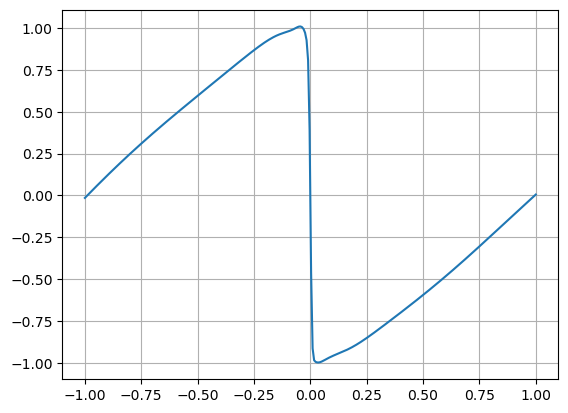

In [410]:
y_locations_test = model((input1[1].to(device)).expand(len(input2_physics),-1),input2_physics.to(device))
plt.plot(x_locations.cpu().detach().numpy(),y_locations_test.cpu().detach().numpy()) 
plt.grid()       

In [80]:
input_time.size(0)

3000

In [81]:
input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)

In [82]:
target_BC1 = torch.zeros(input_time.size(0))

In [83]:
input2.size()

torch.Size([3000, 2])

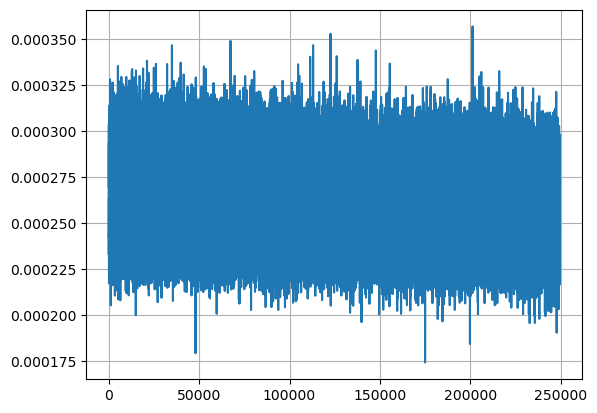

In [ ]:
plt.plot(loss_rec)#[1000:])
plt.grid()

In [139]:
# model(y,torch.tensor([0,0]))